In [1]:
!pip install interpret
!pip install lime
!pip install shap


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import lime

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestClassifier

Data Collection and Analysis

PIMA Diabetes Dataset

In [5]:
# loading the diabetes dataset to a pandas DataFrame
Az_dataset = pd.read_csv('XAI_Assistant_ML/data/alzheimer.csv')

In [6]:
Az_dataset.head()


,Group,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,Nondemented,M,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,Nondemented,M,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,Demented,M,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,Demented,M,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,Demented,M,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [7]:
# number of rows and columns in this dataset
Az_dataset.shape

(373, 10)

In [8]:
Az_dataset = Az_dataset.apply(LabelEncoder().fit_transform)

In [9]:
Az_dataset.head()

,Group,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,2,1,27,5,1,14,0,284,35,1
1,2,1,28,5,1,17,0,285,20,0
2,1,1,15,3,5,10,1,231,73,52
3,1,1,16,3,5,15,1,254,51,32
4,1,1,20,3,5,9,1,238,40,46


In [10]:
# getting the statistical measures of the data
Az_dataset.describe()

,Group,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000
mean,1.410188,0.428954,17.013405,5.611260,1.640751,14.404826,0.573727,142.924933,65.817694,132.217158
std,0.664461,0.495592,7.640957,2.590633,1.351881,3.466379,0.716965,78.136011,32.940301,71.005668
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,11.000000,3.000000,1.000000,14.000000,0.000000,78.000000,39.000000,75.000000
50%,2.000000,0.000000,17.000000,6.000000,1.000000,16.000000,0.000000,144.000000,67.000000,130.000000
75%,2.000000,1.000000,22.000000,7.000000,3.000000,17.000000,1.000000,206.000000,91.000000,192.000000
max,2.000000,1.000000,38.000000,11.000000,5.000000,18.000000,3.000000,285.000000,135.000000,264.000000


In [11]:
Az_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Group   373 non-null    int64
 1   M/F     373 non-null    int64
 2   Age     373 non-null    int64
 3   EDUC    373 non-null    int64
 4   SES     373 non-null    int64
 5   MMSE    373 non-null    int64
 6   CDR     373 non-null    int64
 7   eTIV    373 non-null    int64
 8   nWBV    373 non-null    int64
 9   ASF     373 non-null    int64
dtypes: int64(10)
memory usage: 29.3 KB


# Separating the data and labels

In [13]:
X = Az_dataset.drop(['Group'], axis=1)
Y = Az_dataset['Group']

#Data Standardization

In [15]:
scaler = StandardScaler()

In [16]:
standardized_data = scaler.fit_transform(X)

In [17]:
X = standardized_data
Y = Az_dataset['Group']

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify=Y, random_state=42)

# Gender
# 1	Age
# 2	Education	Years of education
# 3	SES	Socioeconomic Status
# 4	CDR	Clinical Dementia Rating
# 5	MMSE	Mini Mental State Exam
# 6	ETIV	Estimated Total Intracranial Volume
# 7	NWBV	Normalized Whole Brain Volume
# 8	ASF	Atlas Scaling Factor


columns = ['Gender','Age','Education','Socioeconomic Satus','Mini Mental State Exam','Clinical Demential Rating','Estimated Total Intracranial Volume','Normalized Whole Brain Volume','Atlas Scaling Factor']
X_train = pd.DataFrame(X_train, columns=columns)
X_test = pd.DataFrame(X_test, columns=columns)

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, classification_report
from sklearn.model_selection import learning_curve, validation_curve

class ModelEvaluator:
    def __init__(self, model, X_train, X_test, y_train, y_test):
        """
        Initialize the ModelEvaluator with the model and datasets.
        """
        self.model = model
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.y_pred = None

    def train_and_predict(self):
        """
        Train the model and make predictions.
        """
        self.model.fit(self.X_train, self.y_train)
        self.y_pred = self.model.predict(self.X_test)

    def get_metrics_multiclass(self):
        """
        Calculate and print accuracy, recall, precision, and F1-score.
        """
        if self.y_pred is None:
            print("Model is not trained yet! Please call `train_and_predict` first.")
            return

        accuracy = accuracy_score(self.y_test, self.y_pred)
        recall = recall_score(self.y_test, self.y_pred, average='macro')  # Use 'macro' or 'weighted' for multiclass
        f1 = f1_score(self.y_test, self.y_pred, average='macro')
        precision = precision_score(self.y_test, self.y_pred, average='macro')

        print(f"Accuracy: {accuracy}")
        print(f"Recall: {recall}")
        print(f"F1 Score: {f1}")
        print(f"Precision: {precision}")
        print("\nClassification Report:")
        print(classification_report(self.y_test, self.y_pred))

    def plot_learning_curve(self, scoring='accuracy', cv=5):
        """
        Plot the learning curve for the model to visualize bias-variance tradeoff.
        """
        train_sizes, train_scores, test_scores = learning_curve(self.model, self.X_train, self.y_train, cv=cv, scoring=scoring, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5))

        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)
        test_std = np.std(test_scores, axis=1)

        plt.plot(train_sizes, train_mean, label="Training Score", color="blue")
        plt.plot(train_sizes, test_mean, label="Cross-validation Score", color="green")

        plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
        plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="green", alpha=0.2)

        plt.title("Learning Curve")
        plt.xlabel("Training Set Size")
        plt.ylabel(scoring.capitalize())
        plt.legend(loc="best")
        plt.show()

    def plot_validation_curve(self, param_name, param_range, scoring='accuracy', cv=5):
        """
        Plot the validation curve for the model to visualize bias-variance tradeoff for a specific hyperparameter.
        """
        train_scores, test_scores = validation_curve(self.model, self.X_train, self.y_train, param_name=param_name, param_range=param_range, cv=cv, scoring=scoring, n_jobs=-1)

        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)
        test_std = np.std(test_scores, axis=1)

        plt.plot(param_range, train_mean, label="Training Score", color="blue")
        plt.plot(param_range, test_mean, label="Cross-validation Score", color="green")

        plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
        plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="green", alpha=0.2)

        plt.title(f"Validation Curve for {param_name}")
        plt.xlabel(param_name)
        plt.ylabel(scoring.capitalize())
        plt.legend(loc="best")
        plt.xscale('log')
        plt.show()


In [20]:
###################################################################################################################################################################

# ExplainableBoostingClassifier

In [22]:
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

In [23]:
ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, Y_train)

C:\Users\sudhi\Downloads\Sagar_Pathak\IIT_Bhilai\ML\XAI_assistant_ML\XAI_Assistant_ML\Lib\site-packages\interpret\glassbox\_ebm\_ebm.py:1014: UserWarning: Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.
  warn(


ExplainableBoostingClassifier()

In [24]:

from sklearn.metrics import roc_auc_score

auc = roc_auc_score(Y_test, ebm.predict_proba(X_test), multi_class='ovr')  # or 'ovo'
print("AUC: {:.3f}".format(auc))

# As this is multiclass target dataset
# auc = roc_auc_score(Y_test, ebm.predict_proba(X_test)[:, 1])
# print("AUC: {:.3f}".format(auc))

AUC: 0.890


In [25]:
show(ebm.explain_global())

<!-- http://127.0.0.1:7001/3056106981904/ -->

In [26]:
show(ebm.explain_local(X_test, Y_test),0)

<!-- http://127.0.0.1:7001/3056757204672/ -->

C:\Users\sudhi\Downloads\Sagar_Pathak\IIT_Bhilai\ML\XAI_assistant_ML\XAI_Assistant_ML\Lib\site-packages\interpret\glassbox\_ebm\_ebm.py:1014: UserWarning:

Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.



Accuracy: 0.92
Recall: 0.75
F1 Score: 0.773774150798633
Precision: 0.9501291989664082

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.25      0.40         8
           1       0.97      1.00      0.98        29
           2       0.88      1.00      0.94        38

    accuracy                           0.92        75
   macro avg       0.95      0.75      0.77        75
weighted avg       0.93      0.92      0.90        75



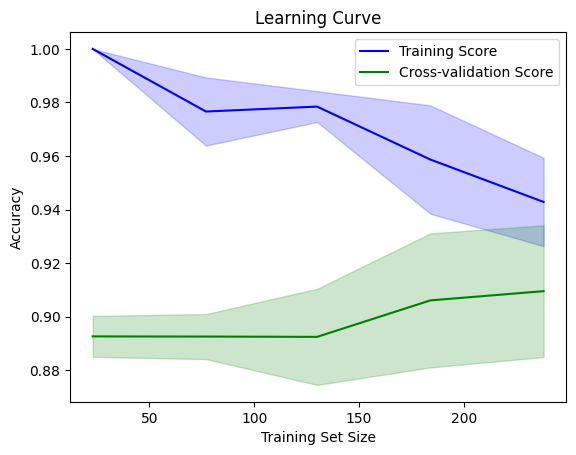

In [27]:
evaluator = ModelEvaluator(ebm, X_train, X_test, Y_train, Y_test)
evaluator.train_and_predict()  # Train the model and get predictions
evaluator.get_metrics_multiclass()        # Get the classification metrics

# Plot the learning curve
evaluator.plot_learning_curve()


In [28]:
################################################################################################################################################################

# Local Interpretable Model-agnostic Explanations (LIME)

In [30]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from interpret import show
from interpret.blackbox import LimeTabular

In [31]:
seed = 42
np.random.seed(seed)

pca = PCA()
rf = RandomForestClassifier(random_state=seed)

blackbox_model = Pipeline([('pca', pca), ('rf', rf)])
blackbox_model.fit(X_train, Y_train)

Pipeline(steps=[('pca', PCA()),
                ('rf', RandomForestClassifier(random_state=42))])

In [32]:
lime = LimeTabular(blackbox_model, X_train)

Accuracy: 0.9066666666666666
Recall: 0.7412280701754387
F1 Score: 0.763888888888889
Precision: 0.9388120839733743

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.25      0.40         8
           1       0.94      1.00      0.97        29
           2       0.88      0.97      0.93        38

    accuracy                           0.91        75
   macro avg       0.94      0.74      0.76        75
weighted avg       0.91      0.91      0.89        75



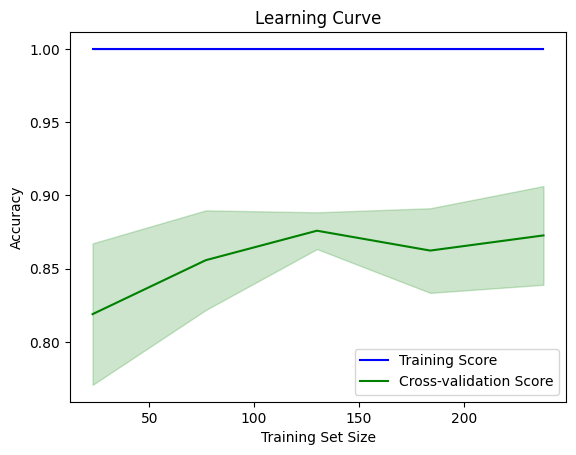

In [33]:
evaluator = ModelEvaluator(blackbox_model, X_train, X_test, Y_train, Y_test)
evaluator.train_and_predict()  # Train the model and get predictions
evaluator.get_metrics_multiclass()        # Get the classification metrics

# Plot the learning curve
evaluator.plot_learning_curve()


In [34]:
# show(lime.explain_local(X_test[:5], Y_test[:5]), 0)

# LIME Cant be used for multiclass classification

In [35]:
#########################################################################################################################################################################################

# Classification Tree

In [37]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from interpret.glassbox import ClassificationTree
from interpret import show

seed = 42
np.random.seed(seed)


In [38]:

dt = ClassificationTree(random_state=seed)
dt.fit(X_train, Y_train)
Y_pred = dt.predict(X_test)


In [39]:

auc = roc_auc_score(Y_test, dt.predict_proba(X_test), multi_class='ovr')
print("AUC: {:.3f}".format(auc))

AUC: 0.863


In [114]:
show(dt.explain_global())

<!-- http://127.0.0.1:7001/3056800552752/ -->

In [41]:
evaluator = ModelEvaluator(dt, X_train, X_test, Y_train, Y_test)
evaluator.train_and_predict()  # Train the model and get predictions
evaluator.get_metrics_multiclass()        # Get the classification metrics


Accuracy: 0.8666666666666667
Recall: 0.7040229885057471
F1 Score: 0.7110255999144887
Precision: 0.7261975750347843

Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.25      0.29         8
           1       0.96      0.86      0.91        29
           2       0.88      1.00      0.94        38

    accuracy                           0.87        75
   macro avg       0.73      0.70      0.71        75
weighted avg       0.86      0.87      0.86        75



In [42]:
#######################################################################################################################################################################################

# SHAP

(Blackbox model)

In [44]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from interpret import show
from interpret.blackbox import ShapKernel

In [45]:
seed = 42
np.random.seed(seed)

pca = PCA()
rf = RandomForestClassifier(random_state=seed)

In [46]:
blackbox_model_shap = Pipeline([('pca', pca), ('rf', rf)])
blackbox_model_shap.fit(X_train, Y_train)

Pipeline(steps=[('pca', PCA()),
                ('rf', RandomForestClassifier(random_state=42))])

In [47]:
# shap = ShapKernel(blackbox_model_shap, X_train)
# shap_local = shap.explain_local(X_test[:5], Y_test[:5])

# Shap does not support multiclass classification

In [48]:
# show(shap_local, 0)

Accuracy: 0.9066666666666666
Recall: 0.7412280701754387
F1 Score: 0.763888888888889
Precision: 0.9388120839733743

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.25      0.40         8
           1       0.94      1.00      0.97        29
           2       0.88      0.97      0.93        38

    accuracy                           0.91        75
   macro avg       0.94      0.74      0.76        75
weighted avg       0.91      0.91      0.89        75



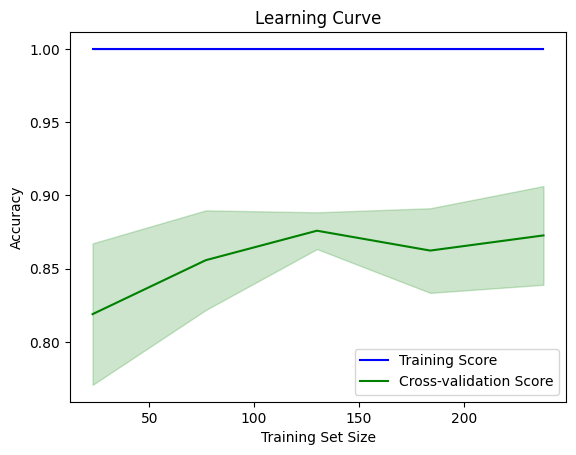

In [49]:
evaluator = ModelEvaluator(blackbox_model_shap, X_train, X_test, Y_train, Y_test)
evaluator.train_and_predict()  # Train the model and get predictions
evaluator.get_metrics_multiclass()        # Get the classification metrics

# Plot the learning curve
evaluator.plot_learning_curve()

In [50]:
###########################################################################################################################################################################

# LogisticRegression Model

In [52]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from interpret.glassbox import LogisticRegression
from interpret import show


In [53]:
seed = 42
np.random.seed(seed)
lr = LogisticRegression(max_iter=3000, random_state=seed)
lr.fit(X_train, Y_train)

In [54]:
auc = roc_auc_score(Y_test, lr.predict_proba(X_test), multi_class='ovr')
print("AUC: {:.3f}".format(auc))

AUC: 0.899


In [55]:
evaluator = ModelEvaluator(lr, X_train, X_test, Y_train, Y_test)
evaluator.train_and_predict()  # Train the model and get predictions
evaluator.get_metrics_multiclass()        # Get the classification metrics


Accuracy: 0.92
Recall: 0.75
F1 Score: 0.773774150798633
Precision: 0.9501291989664082

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.25      0.40         8
           1       0.97      1.00      0.98        29
           2       0.88      1.00      0.94        38

    accuracy                           0.92        75
   macro avg       0.95      0.75      0.77        75
weighted avg       0.93      0.92      0.90        75



In [56]:
show(lr.explain_global())


<!-- http://127.0.0.1:7001/3056800551120/ -->

# Export the model

In [58]:
import pickle
filename = "alzheimer_model.sav"
pickle.dump(lr,open(filename,"wb"))